# Import libraries

In [161]:
import numpy as np
import random
from numpy.linalg import*
import matplotlib.pyplot as plt
from numpy import r_, exp, cos, sin, pi, zeros, ones, hanning, sqrt, log, floor, reshape, mean
from scipy import signal,stats 
from numpy.fft import fft
import math
import time

import scipy.io as sio
import scipy.io.wavfile
import sounddevice as sd
from IPython.display import Audio

import copy
%matplotlib inline
import librosa
import librosa.display


# Problem 1. Discriminant Functions

Text(0.5, 1.0, 'P1-d)')

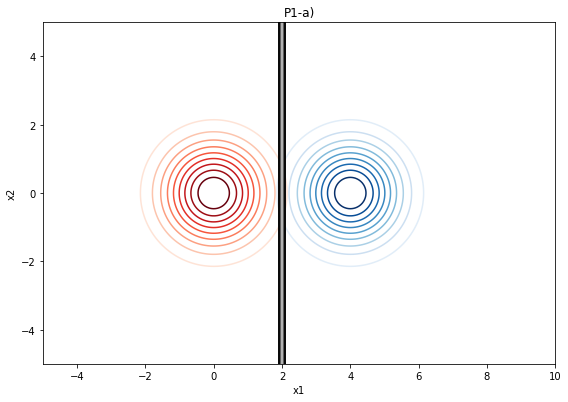

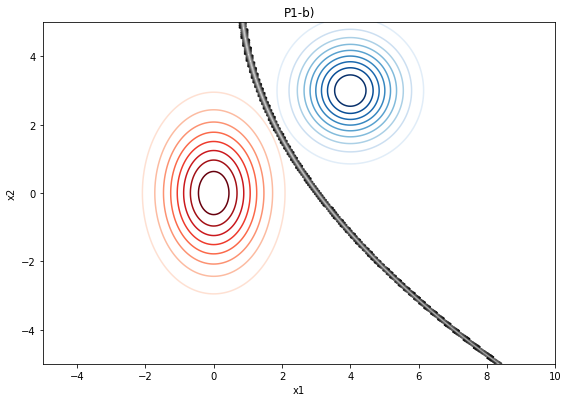

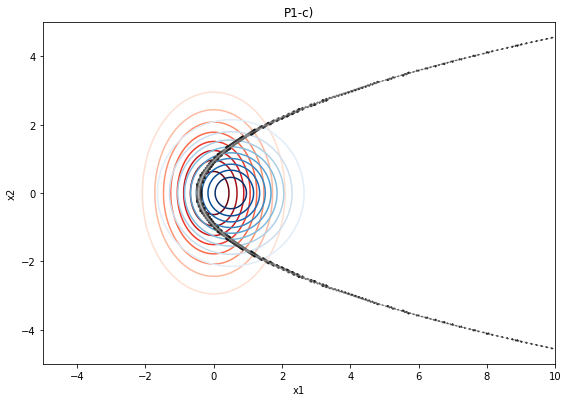

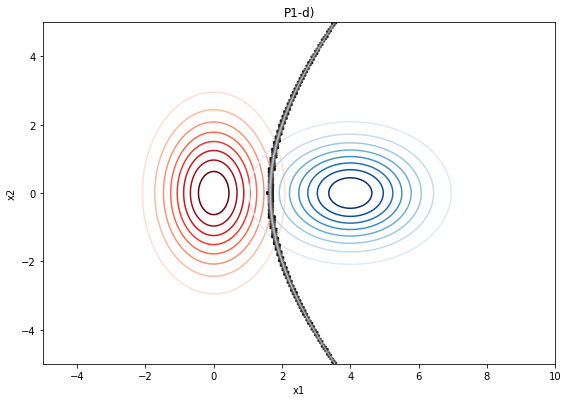

In [162]:
def plot_contour(m1,C1,m2,C2,threshold):
    W1 = -0.5*np.linalg.inv(C1)
    w1 = np.linalg.inv(C1)@m1
    const1 = -0.5*(np.reshape(m1,(1,2))@np.linalg.inv(C1)@m1 + np.log(np.linalg.det(C1)))
    W2 = -0.5*np.linalg.inv(C2)
    w2 = np.linalg.inv(C2)@m2
    const2 = -0.5*(np.reshape(m2,(1,2))@np.linalg.inv(C2)@m2 + np.log(np.linalg.det(C2)))
    g1 = np.einsum('i...,ij,j...',x_vec,W1,x_vec) + np.einsum('i...,i',x_vec,w1) + const1
    g2 = np.einsum('i...,ij,j...',x_vec,W2,x_vec) + np.einsum('i...,i',x_vec,w2) + const2
    dg = abs(g1-g2)
    G = np.ma.array(dg, mask=dg>threshold)

    plt.figure(figsize=(8,8))
    plt.axes().set_aspect("equal")
    plt.contour(x,y,np.exp(g1),levels,alpha=1,cmap='Reds',extend='max')
    #plt.colorbar()
    plt.contour(x,y,np.exp(g2),levels,alpha=1,cmap='Blues',extend='max')
    #plt.colorbar()
    plt.contour(x,y,np.exp(G),levels,cmap='binary',extend='max')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.tight_layout()
    #plt.show()    
#rv1 = scipy.stats.multivariate_normal(m1, C1)
#rv2 = scipy.stats.multivariate_normal(m2, C2)
x = np.linspace(-5,10,300+1)
y = np.linspace(-5,5,300+1)
X, Y = np.meshgrid(x,y)
XY_mesh = np.dstack((X,Y))

#x, y = np.mgrid[-1:1:0.1, -1:1:0.1]
levels = 10
x_vec = np.array([X,Y])

# a)
m1 = np.array([0, 0])
C1 = np.array([[1,0],[0,1]])
m2 = np.array([4, 0])
C2 = np.array([[1,0],[0,1]])
plot_contour(m1,C1,m2,C2,0.5)
plt.title('P1-a)')
# b)
m1 = np.array([0, 0])
C1 = np.array([[1,0],[0,2]])
m2 = np.array([4, 3])
C2 = np.array([[1,0],[0,1]])
plot_contour(m1,C1,m2,C2,0.5)
plt.title('P1-b)')
# b)
m1 = np.array([0, 0])
C1 = np.array([[1,0],[0,2]])
m2 = np.array([0.5, 0])
C2 = np.array([[1,0],[0,1]])
plot_contour(m1,C1,m2,C2,.05)
plt.title('P1-c)')
# b)
m1 = np.array([0, 0])
C1 = np.array([[1,0],[0,2]])
m2 = np.array([4, 0])
C2 = np.array([[2,0],[0,1]])
plot_contour(m1,C1,m2,C2,0.3)
plt.title('P1-d)')

# Problem 2: Handwritten digit recognition

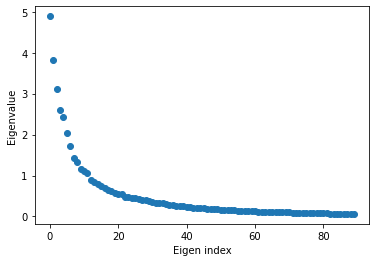

In [163]:
data = np.load('./HW3_data/digits-labels.npz')
X = data['d']
L = data['l']

N_train = 100
X_train = np.zeros((784,N_train,10))

#X_test = np.array([[]])
for i in range(10):
    search_ind = np.argwhere(L==i).flatten()
    X_train[:,:,i] = X[:,search_ind[:N_train]]


X_train_mean = np.average(np.reshape(X_train,(784,-1)),axis=1)
X_train_cov = np.cov(np.reshape(X_train,(784,-1)), bias =True)
EigVal, EigVec = np.linalg.eigh(X_train_cov)

sort_ind = np.argsort(EigVal)[::-1]
EigVal_sort = EigVal[sort_ind]
EigVec_sort = EigVec[:,sort_ind]
Disp = 90
plt.figure(0)
plt.plot(EigVal_sort[:Disp],'o')
plt.xlabel('Eigen index')
plt.ylabel('Eigenvalue')
N_sel = 20

EigVec_sel = EigVec_sort[:,:N_sel]
SigmaInv_sel = np.diag(1/np.sqrt(EigVal_sort[:N_sel]))
W_sel = SigmaInv_sel@np.transpose(EigVec_sel)
Z_train = np.einsum('ij,jkl->ikl', W_sel,(X_train.T-X_train_mean).T)

Z_mean = np.zeros((N_sel,10))
Z_cov  = np.zeros((N_sel,N_sel,10))

for i in range(10):
    Z_mean[:,i] = np.average(Z_train[:,:,i],axis=1)
    Z_cov[:,:,i] = np.cov(Z_train[:,:,i])
    

In [164]:
## Log-likelihood func.
def digit_g_func(Z,mean,cov):
    #Z = np.array(Z)
    A = np.diag(-0.5*(Z.T-mean)@np.linalg.inv(cov)@(Z.T-mean).T)
    B = 0.5*len(mean)*np.log(2*np.pi)+0.5*np.log(np.linalg.det(cov))
    return A-B

def digit_eval(X):
    Z_test = W_sel@(X.T-X_train_mean).T
    temp = []
    Out = np.array([(digit_g_func(Z_test,Z_mean[:,k],Z_cov[:,:,k])) for k in range(10)])
    return np.argmax(Out,axis=0)

    
## Test (Validation)
acc = np.zeros(10)
for i in range(10):
    search_ind = np.argwhere(L==i).flatten()
    X_test = X[:,search_ind[N_train:]]
    acc[i] = len(np.argwhere(digit_eval(X_test)==i).flatten())/len(X_test[0,:])

print(np.round(acc*100,0))    
print('Average accuracy: ',np.average(acc)*100)
#plt.plot(acc*100)

[95. 87. 91. 84. 91. 89. 96. 88. 95. 85.]
Average accuracy:  90.05022351971046


- Average accuracy with respect to N_sel(number of features)

| N_sel       | 1    |  5  | 10 |15|16  |17  |18   |19   | 20  |22  | 25 | 30 | 40  | 50 |
| ----------- | ---- |-----|----|--|--- |--- |--   |--   |---  | ---|--- |----| --- | --|
| Accuracy(%) | 28.4 |66.8 |84.3|89|89.5|90.0|90.7 |90.5 | 90.1|90.0|90.4|90.6|89.5 |88|

: Interestingly, accuracy hits peak near N_sel of 20 then starts to drop. 
When N_sel is too low, it is not complete enough to capture enough features for good learning but 
when N_sel is too high, overfitting can happen which results in validation accuracy reduction.



# Problem 3: Speech / No speech classifier

In [165]:
## Data import

N_train = 6

Speech_data = np.zeros((60,fs*15))
Music_data = np.zeros((60,fs*15))


S_test = np.array([])
M_test = np.array([])
for i in range(60):
    Speech_data[i,:], fs = librosa.load('./HW3_data/SpeechMusic/speech/'+str(i+1)+'.wav', sr=None)
    Music_data[i,:], fs = librosa.load('./HW3_data/SpeechMusic/music/'+str(i+1)+'.wav', sr=None)


[52 32 47  9 46  9]
(513, 513)


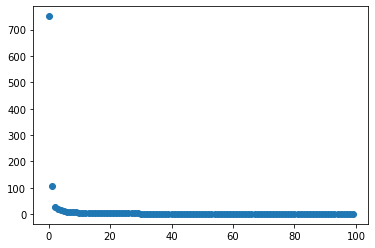

In [182]:
Rand_array = np.random.choice(60,6)
print(Rand_array)
S_train = np.reshape(Speech_data[Rand_array,:],(-1))
M_train = np.reshape(Music_data[Rand_array,:],(-1))
S_test_mat = np.delete(Speech_data,Rand_array,axis=0)
M_test_mat = np.delete(Music_data,Rand_array,axis=0)

### STFT on training data
N_fft = 1024
N_hop = 0.25*N_fft
f,t,S_ft_train = signal.stft(S_train, fs, window = 'hamming', nperseg=N_fft, noverlap = N_fft-N_hop)
f,t,M_ft_train = signal.stft(M_train, fs, window = 'hamming', nperseg=N_fft, noverlap = N_fft-N_hop)
S_ft_train = np.log(abs(S_ft_train))
M_ft_train = np.log(abs(M_ft_train))
X_ft_train = np.hstack((S_ft_train, M_ft_train))

X_train_mean = np.average(X_ft_train,axis=1)  

##### : PCA #####
# Z = WX  
# where Z: weight matrix (3 x 349), W: feature matrix (3 x 513), X: input matrix (513 x 349)


X_cov = np.cov((X_ft_train.T-X_train_mean).T, bias =True)
print(X_cov.shape)
EigVal, EigVec = np.linalg.eigh(X_cov)

sort_ind = np.argsort(EigVal)[::-1]
EigVal_sort = EigVal[sort_ind]
EigVec_sort = EigVec[:,sort_ind]
Disp = 100
plt.figure(0)
plt.plot(EigVal_sort[:Disp],'o')
N_sel = 10

EigVec_sel = EigVec_sort[:,:N_sel]


SigmaInv_sel = np.diag(1/np.sqrt(EigVal_sort[:N_sel]))

W_sel = SigmaInv_sel@np.transpose(EigVec_sel)
Z_train_S = W_sel@(S_ft_train.T-X_train_mean).T
Z_train_M = W_sel@(M_ft_train.T-X_train_mean).T

## Learn Gaussian parameters from speech and music training set respectively
Z_mean_S = np.average(Z_train_S,axis=1)
Z_cov_S = np.cov(Z_train_S)

Z_mean_M = np.average(Z_train_M,axis=1)
Z_cov_M = np.cov(Z_train_M)



In [183]:
## Log-likelihood func.
def sound_g_func(Z,mean,cov):
    #Z = np.array(Z)
    A = np.diag(-0.5*(Z.T-mean)@np.linalg.inv(cov)@(Z.T-mean).T)
    B = 0.5*len(mean)*np.log(2*np.pi)+0.5*np.log(np.linalg.det(cov))
    return A-B

def sound_eval(x):
    _,_,X_ft = signal.stft(x, fs, window = 'hamming', nperseg=N_fft, noverlap = N_fft-N_hop)
    X = np.log(abs(X_ft))
    
    Z_test = W_sel@(X.T-X_train_mean).T
    temp = []
    Out_S = sound_g_func(Z_test,Z_mean_S,Z_cov_S)
    Out_M = sound_g_func(Z_test,Z_mean_M,Z_cov_M)
    Out = np.vstack((Out_S,Out_M))
    #return Out
    return np.argmax(Out,axis=0)    ##### 0 for S,   1 for M


### Testing
temp = []
Right_count = 0
count = 0
for i in range(60-N_train):
    for j in range(15):
        if stats.mode(sound_eval(S_test_mat[i,j*fs:(j+1)*fs]))[0] == 0:
            Right_count += 1
        if stats.mode(sound_eval(M_test_mat[i,j*fs:(j+1)*fs]))[0] == 1:
            Right_count += 1
    count += 1
print('Accuracy (%) :', np.around(100*Right_count/(30*count),2))



Accuracy (%) : 88.89


- Recognition rate (RR) with different training set (with corresponding testing set) is found.

| Combination | 1    |  2 | 3   |4    |5   |6   |7    |8    | 9  |10   | Avg |
| ----------- | ---- |-----|----|--   |--- |--- |--   |--   |---  | ---|---- |
| RR(%)       |92.4  |89.1 |95.6|95.4 |89.1|81.2|94.2 |92.3 |88.1 |93.2|91.1 | 

:N_sel of 10 is chosen to perform PCA to reduce dimension to 10.

In [184]:
#### P3. own voice and music
Speech_own, fs_S = librosa.load('./HW3_data/cs545_HSVoice.wav', sr=None)
Music_own_BTS, fs_M_BTS = librosa.load('./HW3_data/BTS_DYNAMITE.wav', sr=None)
Music_own_Shire, fs_M_Shire = librosa.load('./HW3_data/Shire.wav', sr=None)

S_own = librosa.resample(Speech_own,fs_S, fs, res_type='scipy')[:15*fs] ## Resampled to 22050 Hz
M_own_BTS = librosa.resample(Music_own_BTS,fs_M_BTS, fs, res_type='scipy')[:15*fs]  ## Resampled to 22050 Hz
M_own_Shire = librosa.resample(Music_own_Shire,fs_M_Shire, fs, res_type='scipy')[5*fs:20*fs]  ## Resampled to 22050 Hz
  

### Recorded voice of my own

In [169]:
Audio(S_own,rate=fs)  

### BTS- Dynamite Music

In [170]:
Audio(M_own_BTS,rate=fs)    

 ### LOTR- Shire Music

In [171]:
Audio(M_own_Shire,rate=fs)   

## - Trial 1: Own voice recordings (15-seconds long)

In [185]:
### Testing with own voice using trained classifier 
temp = []
Right_count = 0

for j in range(15):
    if stats.mode(sound_eval(S_own[j*fs:(j+1)*fs]))[0] == 0:
        Right_count += 1

print('Accuracy (%) :', np.around(100*Right_count/(15),2))


Accuracy (%) : 100.0


## - Trial 2: BTS-dynamite (15-seconds long)

In [186]:
### Testing with own voice using trained classifier 
temp = []
Right_count = 0

for j in range(15):
    if stats.mode(sound_eval(M_own_BTS[j*fs:(j+1)*fs]))[0] == 1:
        Right_count += 1

print('Accuracy (%) :', np.around(100*Right_count/(15),2))


Accuracy (%) : 53.33


## - Trial 3: LOTR-Shire (15-seconds long)

In [187]:
### Testing with own voice using trained classifier 
temp = []
Right_count = 0

for j in range(15):

    if stats.mode(sound_eval(M_own_Shire[j*fs:(j+1)*fs]))[0] == 1:
        Right_count += 1

print('Accuracy (%) :', np.around(100*Right_count/(15),2))

Accuracy (%) : 100.0


## Q: Why shire music works but BTS music doesn't? (or the other way around)  --> BTS music has human voice all the time while Shire music doesn't have human voice. Therefore accuracy depends on music's training dataset whether it contained voice in music or not.